# Processing your Data with stripmapApp.py

**Author**: Heresh Fattahi, Piyush Agram, updated for 2022 and 2023 Eric Fielding

In this notebook, we will walk through the various steps of processing with stripmapApp.py. 

stripmapApp.py is a pair-by-pair interferometric processor that takes as input two SAR acquisitions acquired in stripmap mode. stripmapApp.py will not work for other acquisition mode such as TOPS or ScanSAR. At this time, ISCE's topsApp supports TOPS mode acquisitions in SLC data format from Sentinel-1 A and B. Processing of stripmap data is supported from RAW or SLC level data inputs.

To illustrate the usage of stripApp.py, we will use a JAXA ALOS dataset capturing the surface deformation as result of the March 2011 Kamoamoa dike intrusion and fissure eruption that occurred on Kilauea in Hawaii.

# stripmap acquisition mode

In conventional stripmap Synthetic Aperture Radar(SAR) imaging mode, the radar antenna
is fixed to a specific direction, illuminating a single swath of the scene with a fixed squint angle (i.e., the angle between the radar beam and the cross-track direction). The imaging swath width can be increased using the scanning SAR (ScanSAR) or Terrain Observation by Progressive Scan(TOPS). In this notebook we focus on interferometric processing of stripmap data using **stripmapApp.py**. 

The stripmap mode has been used by several SAR missions, such as Envisat, ERS, RadarSAT-1, Radarsat-2, ALOS-1, Cosmo Sky-Med and TerraSAR-X. Although Sentinel-1 A/B and ALOS-2 are capable of acquiring SAR data with stripmap mode, their operational imaging modes are TOPS and ScanSAR respectively. Both missions have been acquiring stripmap data over certain regions.

For processing TOPS data using topsApp, please see the topsApp notebook. However, we recommend that new InSAR users may start with the stripmapApp notebook first, and then try the topsApp notebook. 

The detailed algorithms for stripmap processing and TOPS processing implemented in ISCE software can be found in the following literatures:

### stripmapApp:

H. Fattahi, M. Simons, and P. Agram,  "InSAR Time-Series Estimation of the Ionospheric Phase Delay: An Extension of the Split Range-Spectrum Technique", IEEE Trans. Geosci. Remote Sens., vol. 55, no. 10, 5984-5996, 2017.
(https://ieeexplore.ieee.org/abstract/document/7987747/)

### topsApp:

H. Fattahi, P. Agram, and M. Simons, “A network-based enhanced spectral diversity approach for TOPS time-series analysis,” IEEE Trans. Geosci. Remote Sens., vol. 55, no. 2, pp. 777–786, Feb. 2017. (https://ieeexplore.ieee.org/abstract/document/7637021/)

### ISCE framework:
Rosen et al, IGARSS 2018 [Complete reference here] 

![title](notebook_docs/Stripmap_Tops.png)

(Figure from Fattahi et. al., 2017)

# stripmapApp (general overview)

**stripmapApp.py** is an ISCE application, designed for interferometric processing of SAR data acquired with stripmap mode onboard platforms with precise orbits. This ISCE application is equivalent to insarApp (an older ISCE application which was widely used by ISCE users), in this sense that both apps process stripmap data. Although the naming convention of the products and interface of the App is similiar to insarApp, the core modules used in stripmapApp are fundamentally different. The main features of stripmapApp includes the following:

#### a) Focusing RAW data to native Doppler:

If processing starts from RAW data, JPL's ROI software is used for focusing the raw data to SLC(Single Look Complex) SAR images in native Doppler geometry. stripmapApp does not use the motion compensation algorithm which was used in insarApp. 

#### b) Interferometric processing of SLCs in native or zero Doppler geometry 
If the input data are SLC images, then focusing is not required and will be skipped. stripmapApp can process SLCs focused to zero or native Dopplers

#### c) Coregistration using SAR acquisition geometry (Orbit + DEM) 
The geometry module of ISCE is used for coregistration of SAR images, i.e., range and azimuth offsets are computed for each pixel using SAR acquisition geometry, orbit information and an existing Digital Elevation Model(DEM). The geometrical offsets are refined with a small constant shift in range and azimuth directions. The constant shifts are estimated using incoherent cross-correlation of the two SAR images already coregistered using pure geometrical information. 

#### d) More optional precise coregistration step
An optional step called "rubbersheeting" is available for more precise coregistration. If "rubbersheeting" is requested, a dense azimuth offsets is computed using incoherent cross-correlation between the two SAR images, and is added to the geometrical offsets for more precise coregistration. Rubbersheeting may be required if SAR images are affected by ionospheric scintillation. 

#### e) Ionospheric phase estimation
Split Range-Spectrum technique and ionospheric phase estimation are available as optional processing steps.



# Prepare directories, download raw data

Importing some python modules and setting up some variables: 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from tqdm import tqdm
import urllib.request
import boto3                      # For talking to s3 bucket
from botocore import UNSIGNED # NEW Change
from botocore.client import Config # NEW Change

#
ASF_USER = ""
ASF_PASS = ""

# the working directory:
home_dir = os.path.join(os.getenv("HOME"), "work")
PROCESS_DIR = os.path.join(home_dir, "Hawaii_ALOS1")
DATA_DIR =  os.path.join(PROCESS_DIR, "data")


# if the ASF user/pass is not provided above, try to read it from ~/.netrc file
if len(ASF_PASS)==0 | len(ASF_USER)==0:
    if os.path.exists(os.path.join(os.getenv("HOME"), ".netrc")):
        ASF_USER = np.loadtxt(os.path.join(os.getenv("HOME"), ".netrc"), skiprows=1, usecols=1, dtype=str)[0]
        ASF_PASS = np.loadtxt(os.path.join(os.getenv("HOME"), ".netrc"), skiprows=1, usecols=1, dtype=str)[1]


if len(ASF_PASS)==0 | len(ASF_USER)==0:
    print("ERROR: The ASF USER pass needs to be set either at this cell or should be included in ~/.netrc file") 

# defining backup dirs in case of download issues on the local server
# boto3 is package to access AWS S3 bucket from Python
# not presently used
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
data_backup_bucket = s3.Bucket("asf-jupyter-data-west")
data_backup_dir = "stripmap_Hawaii"

# Utility to copy data from 
def copy_from_bucket(file_in_bucket, dest_file,
                    bucket=data_backup_bucket):
    if os.path.exists(dest_file):
        print("Destination file {0} already exists. Skipping download...".format(dest_file))
    else:
        bucket.download_file(file_in_bucket, dest_file)


In [2]:
def configure_inputs(outDir): 

    """Write Configuration files for ISCE2 stripmapApp to process NISAR sample products"""
    cmd_reference_config = '''<component>
    <property name="IMAGEFILE">
       <value>[data/20110119/ALPSRP265743230-L1.0/IMG-HH-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110119/ALPSRP265743230-L1.0/LED-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110119</value>
    </property>
</component>'''

    print("writing reference.xml")
    with open(os.path.join(outDir,"reference.xml"), "w") as fid:
        fid.write(cmd_reference_config)
    
    cmd_secondary_config = '''<component>
    <property name="IMAGEFILE">
        <value>[data/20110306/ALPSRP272453230-L1.0/IMG-HH-ALPSRP272453230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110306/ALPSRP272453230-L1.0/LED-ALPSRP272453230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110306</value>
    </property>

</component>'''
    
    print("writing secondary.xml")
    with open(os.path.join(outDir,"secondary.xml"), "w") as fid:
        fid.write(cmd_secondary_config)

    
    cmd_stripmap_config = '''<?xml version="1.0" encoding="UTF-8"?>
<stripmapApp>
  <component name="insar">
    <property name="sensor name">ALOS</property>
    <component name="reference">
        <catalog>reference.xml</catalog>
    </component>
    <component name="secondary">
        <catalog>secondary.xml</catalog>
    </component>

    <!--
    <property name="demFilename">
        <value>stripmap_Hawaii/demLat_N18_N21_Lon_W157_W154.dem.wgs84</value>
    </property>
    -->

    <property name="unwrapper name">icu</property>

    <property name="do split spectrum">False</property>

    <property name="do dispersive">False</property>

</component>
</stripmapApp>'''

    print("writing stripmapApp.xml")
    with open(os.path.join(outDir,"stripmapApp.xml"), "w") as fid:
        fid.write(cmd_stripmap_config)

Check if the PROCESS_DIR and DATA_DIR already exist. If they don't exist, we create them:

In [3]:

if not os.path.exists(PROCESS_DIR):
    print("create ", PROCESS_DIR)
    os.makedirs(PROCESS_DIR)
else:
    print(PROCESS_DIR, " already exists!")

if not os.path.exists(DATA_DIR):
    print("create ", DATA_DIR)
    os.makedirs(DATA_DIR)
else:
    print(DATA_DIR, " already exists!")

os.chdir(DATA_DIR)

/home/jovyan/work/Hawaii_ALOS1  already exists!
/home/jovyan/work/Hawaii_ALOS1/data  already exists!


In this tutorial we will process two ALOS1 PALSAR acquistions over Hawaii. The two acquisitions cover a dike opening even in March 2011.
![title](notebook_docs/Hawaii.png)

Download two ALOS-1 acquistions from ASF using the following command:


In [4]:
cmd = "wget  https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP265743230-L1.0.zip --user={0} --password={1}".format(ASF_USER, ASF_PASS)
if not os.path.exists(os.path.join(DATA_DIR, "ALPSRP265743230-L1.0.zip")):
    os.system(cmd)
else:
    print("ALPSRP265743230-L1.0.zip already exists")
    
cmd = "wget  https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP272453230-L1.0.zip --user={0} --password={1}".format(ASF_USER, ASF_PASS)
if not os.path.exists(os.path.join(DATA_DIR, "ALPSRP272453230-L1.0.zip")):
    os.system(cmd)
else:
    print("ALPSRP272453230-L1.0.zip already exists")

ALPSRP265743230-L1.0.zip already exists
ALPSRP272453230-L1.0.zip already exists


Now the data should be downloading from ASF. If the download did not start, then check your `.netrc` file has your EarthData login. You can also download with the SSARA command below.

In [5]:
#Alternative ssara command
#!ssara_federated_query.py --platform=ALOS --intersectsWith='POLYGON((-155.3 19.5, -155.3 19.8,-155.0 19.8,-155.0 19.5, -155.3 19.5 ))' --print --kml --flightDirection=D --beamMode=FBS,FBD --relativeOrbit=598   -s 2011-01-17 -e 2011-03-07 --download

In [6]:
ls 

20110119/  ALPSRP265743230-L1.0/     ALPSRP272453230-L1.0/
20110306/  ALPSRP265743230-L1.0.zip  ALPSRP272453230-L1.0.zip


unzip the downloaded files

In [7]:
if not os.path.exists(os.path.join(DATA_DIR, "ALPSRP265743230-L1.0")):
    !unzip ALPSRP265743230-L1.0.zip
if not os.path.exists(os.path.join(DATA_DIR, "ALPSRP272453230-L1.0")):
    !unzip ALPSRP272453230-L1.0.zip

 looking at the unzipped directories there are multiple files:

In [8]:
ls ALPSRP265743230-L1.0

ALPSRP265743230.l0.workreport   LED-ALPSRP265743230-H1.0__D  workreport
IMG-HH-ALPSRP265743230-H1.0__D  TRL-ALPSRP265743230-H1.0__D
IMG-HV-ALPSRP265743230-H1.0__D  VOL-ALPSRP265743230-H1.0__D


When you download PALSAR data from a data provider, each frame comprises an image data file (or two in this example of dual-polarization data) and an image leader file, as well as possibly some other ancillary files that are not used by ISCE.  

Files with IMG as prefix are images. 
Files with LED as prefix are leaders. 

The leader file contains parameters of the sensor that are relevant to the imaging mode, all the information necessary to process the data.  The data file contains the raw data samples if Level 1.0 raw data (this is just a different name from what other satellites call Level 0) and processed imagery if Level 1.1 (SLC) or 1.5 (ground-range detected) image data.  The naming convention for these files is standardized across data archives, and has the following taxonomy:


![title](notebook_docs/ALOS1_PALSAR.png)


To see the acquisition date of this PALSAR acquisition we can look at the following file:

In [9]:
!cat ALPSRP265743230-L1.0/ALPSRP265743230.l0.workreport

Odi_ProductManagementNo            = "X0200065"
Odi_ProductManagementBranchNo      = "815"
Scs_SceneID                        = "ALPSRP265743230"
Pds_ProductID                      = "H1.0__D"
Pds_OrbitDataPrecision             = "Precision"
Pds_AttitudeDataPrecision          = "Standard"
Img_SceneCenterDateTime            = "20110119 20:33:44.268"
Img_SceneStartDateTime             = "20110119 20:33:36.068"
Img_SceneEndDateTime               = "20110119 20:33:52.468"
Img_NoOfPSR10LossLines             = "0"
Pdi_ProductDataSize                = "756.4"
Pdi_CntOfL10ProductFileName        = "5"
Pdi_L10ProductFileName01           = "VOL-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName02           = "LED-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName03           = "IMG-HH-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName04           = "IMG-HV-ALPSRP265743230-H1.0__D"
Pdi_L10ProductFileName05           = "TRL-ALPSRP265743230-H1.0__D"
Pdi_NoOfPixels                     = "5968"
Pdi_NoOfLines  

In [10]:
!grep Img_SceneCenterDateTime ALPSRP265743230-L1.0/ALPSRP265743230.l0.workreport
!grep Img_SceneCenterDateTime ALPSRP272453230-L1.0/ALPSRP272453230.l0.workreport

Img_SceneCenterDateTime            = "20110119 20:33:44.268"
Img_SceneCenterDateTime            = "20110306 20:32:42.519"


for clarity let's create two directories for the two acquisition dates and move the unziped folders there:

In [11]:
!mkdir 20110119
!mkdir 20110306
!mv ALPSRP265743230-L1.0 20110119
!mv ALPSRP272453230-L1.0 20110306

mkdir: cannot create directory ‘20110119’: File exists
mkdir: cannot create directory ‘20110306’: File exists
mv: cannot move 'ALPSRP265743230-L1.0' to '20110119/ALPSRP265743230-L1.0': Directory not empty
mv: cannot move 'ALPSRP272453230-L1.0' to '20110306/ALPSRP272453230-L1.0': Directory not empty


Now that we have the data ready let's cd to the main PROCESS directroy

In [12]:
os.chdir(PROCESS_DIR)

To make sure where we are, run pwd:

In [13]:
!pwd

/home/jovyan/work/Hawaii_ALOS1


# Setting up input xml files for processing with stripmapApp

Create the input configuration files (refernce.xml, secondary.xml, stripmapApp.xml) to configure the inputs and the processing parameters.
The configurations files can be created using your favorit editor or by calling the "configure" funstion which is defined at the top of this notebook:


In [14]:
configure_inputs(PROCESS_DIR)

writing reference.xml
writing secondary.xml
writing stripmapApp.xml


Here is an example refernce.xml file for this tutorial:

### reference.xml

```xml
<component>
    <property name="IMAGEFILE">
       <value>[data/20110119/ALPSRP265743230-L1.0/IMG-HH-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110119/ALPSRP265743230-L1.0/LED-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110119</value>
    </property>
</component>
```

### secondary.xml

```xml
<component>
    <property name="IMAGEFILE">
        <value>[data/20110306/ALPSRP272453230-L1.0/IMG-HH-ALPSRP272453230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110306/ALPSRP272453230-L1.0/LED-ALPSRP272453230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110306</value>
    </property>

</component>
```

### stripmapApp.xml



```xml
<?xml version="1.0" encoding="UTF-8"?>
<stripmapApp>
  <component name="insar">
    <property name="sensor name">ALOS</property>
    <component name="reference">
        <catalog>reference.xml</catalog>
    </component>
    <component name="secondary">
        <catalog>secondary.xml</catalog>
    </component>

    <!--  
    <property name="demFilename">
        <value>stripmap_Hawaii/demLat_N18_N21_Lon_W157_W154.dem.wgs84</value>
    </property>
    -->
      
    <property name="unwrapper name">icu</property>
     
</component>
</stripmapApp>
```

<br>
<div class="alert alert-info">
<b>Note :</b> 

demFilename is commented out in the stripmapApp.xml. This means that user has not specified the DEM. Therefore, isce looks online and download the SRTM dem.

</div>


After downloading the data to process, and setting up the input xml files, we are ready to start processing with stripmapApp. To see a full list of the processing steps run the following command:

In [15]:
!stripmapApp.py --help --steps

2023-08-05 21:02:28,893 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 

    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data to geocoded, flattened interferograms.
    
The currently supported sensors are:  ['ALOS', 'ALOS2', 'ALOS_SLC', 'COSMO_SKYMED', 'COSMO_SKYMED_SLC', 'ENVISAT', 'ENVISAT_SLC', 'ERS', 'ERS_ENVISAT', 'ERS_ENVISAT_SLC', 'ERS_SLC', 'ICEYE_SLC', 'KOMPSAT5', 'RADARSAT1', 'RADARSAT2', 'RISAT1', 'RISAT1_SLC', 'ROI_PAC', 'SAOCOM_SLC', 'SENTINEL1', 'SICD_RGZERO', 'TERRASARX', 'UAVSAR_HDF5_SLC', 'UAVSAR_POLSAR', 'UAVSAR_RPI', 'UAVSAR_STACK']

Usages: 
stripmapApp.py <input-file.xml>
stripmapApp.py --steps
stripmapApp.py --help
stripmapApp.py --help --steps


    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data

# stripmapApp processing steps

The default setting of this App includes the following steps to generate a geocoded interferogram from raw data or SLC images:

'startup', 'preprocess', 
'formslc',
'verifyDEM', 
'topo', 
'geo2rdr', 
'coarse_resample', 
'misregistration', 
'refined_resample', 
'interferogram', 
'filter', 
'unwrap', 
'geocode'

<br>
<div class="alert alert-info">
<b>Note (to process the interferogram with one command):</b> 

stripmapApp.py stripmapApp.xml --start=startup --end=endup

</div>

However in this tutorial we process the interferogram step by step.

<br>
<div class="alert alert-info">
<b>At the end of each step, you will see a mesage showing the remaining steps:</b> 

The remaining steps are (in order):  [.....]
</div>


### pre-processing

In [16]:
!stripmapApp.py stripmapApp.xml --start=startup --end=preprocess

2023-08-05 21:02:29,496 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:02:29,498 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:02:29,521 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step startup

    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data to geocoded, flattened interferograms.
    
The currently supported sensors are:  ['ALOS', 'ALOS2', 'ALOS_SLC', 'COSMO_SKYMED', 'COSMO_SKYMED_SLC', 'ENVISAT', 'ENVISAT_SLC', 'ERS', 'ERS_ENVISAT', 'ERS_ENVISAT_SLC', 'ERS_SLC', 'ICEYE_SLC', 'KOMPSAT5', 'RADARSAT1', 'RADARSAT2', 'RISAT1', 'RISAT1_SLC', 'ROI_PAC', 'SAOCOM_SLC', 'SENTINEL1', 'SICD_RGZERO', 'TERRASARX', 'UAVSAR_HDF5_SLC', 'UAVSAR_POLSAR

By the end of "preprocess", the following folders are created:

20110119_raw

20110306_raw

If you look into one of these folders:

In [17]:
ls 20110119_raw

20110119.iq.vrt  20110119.raw      20110119.raw.PRM  20110119.raw.xml
20110119.iq.xml  20110119.raw.aux  20110119.raw.vrt


20110119.raw contains the raw data (I/Q real and imaginary parts of each pulse, sampled along track (azimuth direction) with Pulse Repitition Frequency (PRF) and across track(range direction) with Range Sampling Frequency. stripmapApp currently only handles data acquired (or resampled) to a constant PRF. The data is still the raw data (which JAXA calls level 1.0 and other providers call level 0) but it is converted with all the required metadatato the ISCE format.

### crop raw data

In [18]:
!stripmapApp.py stripmapApp.xml --start=cropraw --end=cropraw

2023-08-05 21:06:49,658 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:06:49,660 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:06:49,683 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step cropraw
No region of interesting provided, skipping cropping of raw data
Dumping the application's pickle object _insar to file  PICKLE/cropraw
The remaining steps are (in order):  ['formslc', 'cropslc', 'verifyDEM', 'topo', 'geo2rdr', 'coarse_resample', 'misregistration', 'refined_resample', 'dense_offsets', 'rubber_sheet_range', 'rubber_sheet_azimuth', 'fine_resample', 'split_range_spectrum', 'sub_band_resample', 'interferogram', 'sub_band_interferogram', 'filter', 'filter_low_band', 'filter_high_band', 'unw

The "cropraw" step would crop the raw data based on the region of interest if it was requested in the stripmapApp.xml. The region of interest can be added to stripmapApp.xml as:
```xml
<property name="regionOfInterest">[19.0, 19.9, -155.4, -154.7]</property>
```

Since we have not sopecified the region of interest, then "cropraw" will be ignored and the whole frame will be processed.

### focusing 

In [19]:
!stripmapApp.py stripmapApp.xml --start=formslc --end=formslc

2023-08-05 21:06:50,451 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:06:50,452 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:06:50,476 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step formslc
Heading:  -167.77877452757056
SCH velocity:  [7598.090629362754, -1.5916157281026244e-12, -3.197111008998945]
SCH acceleration:  [-0.003167355132675187, -0.3502147554533064, -8.15752653864368]
Body velocity:  7598.091302000055
Height:  696451.4159436714
Radius:  6343504.790327209
Lookside:  -1
API open (R): 20110119_raw/20110119.raw
Estimated SLC Starting Range:  948796.0
API open (WR): 20110119_slc/20110119.slc
 ROI - Repeat Orbit Interferometric processor
 
 actual orbital pulse spacing    3.95860577

By the end of "formslc", the raw data for both reference and secondary images are focused to single-look complex (SLC) images. JAXA calls the SLC products level 1.1 and other providers call it level 1. Many satellite providers only provide SLC products, not raw data, so for many satellites, the stripmap processing starts with the SLC data.

In [20]:
ls 20110119_slc

20110119.slc  20110119.slc.vrt  20110119.slc.xml


20110119.slc: Single Look Comlex image for 20110119 acquisition. 

20110119.slc.vrt: A gdal VRT file which contains the size, data type, etc.

20110119.slc.xml: ISCE xml metadat file

In order to see the number of lines and pixels for an SLC image (or any data readable by GDAL):

In [21]:
!gdalinfo 20110119_slc/20110119.slc

Driver: ISCE/ISCE raster
Files: 20110119_slc/20110119.slc
       20110119_slc/20110119.slc.xml
Size is 5562, 27648
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (0.000000000000000,0.000000000000000)
Pixel Size = (1.000000000000000,1.000000000000000)
Corner Coordinates:
Upper Left  (   0.0000000,   0.0000000) (  0d 0' 0.01"E,  0d 0' 0.01"N)
Lower Left  (       0.000,   27648.000) (  0d 0' 0.01"E,Invalid angle)
Upper Right (    5562.000,       0.000) (Invalid angle,  0d 0

Display a subset of SLC's amplitude and phase. In the amplitude image, we can see the coast of the big island of Hawaii that is covered by this scene.

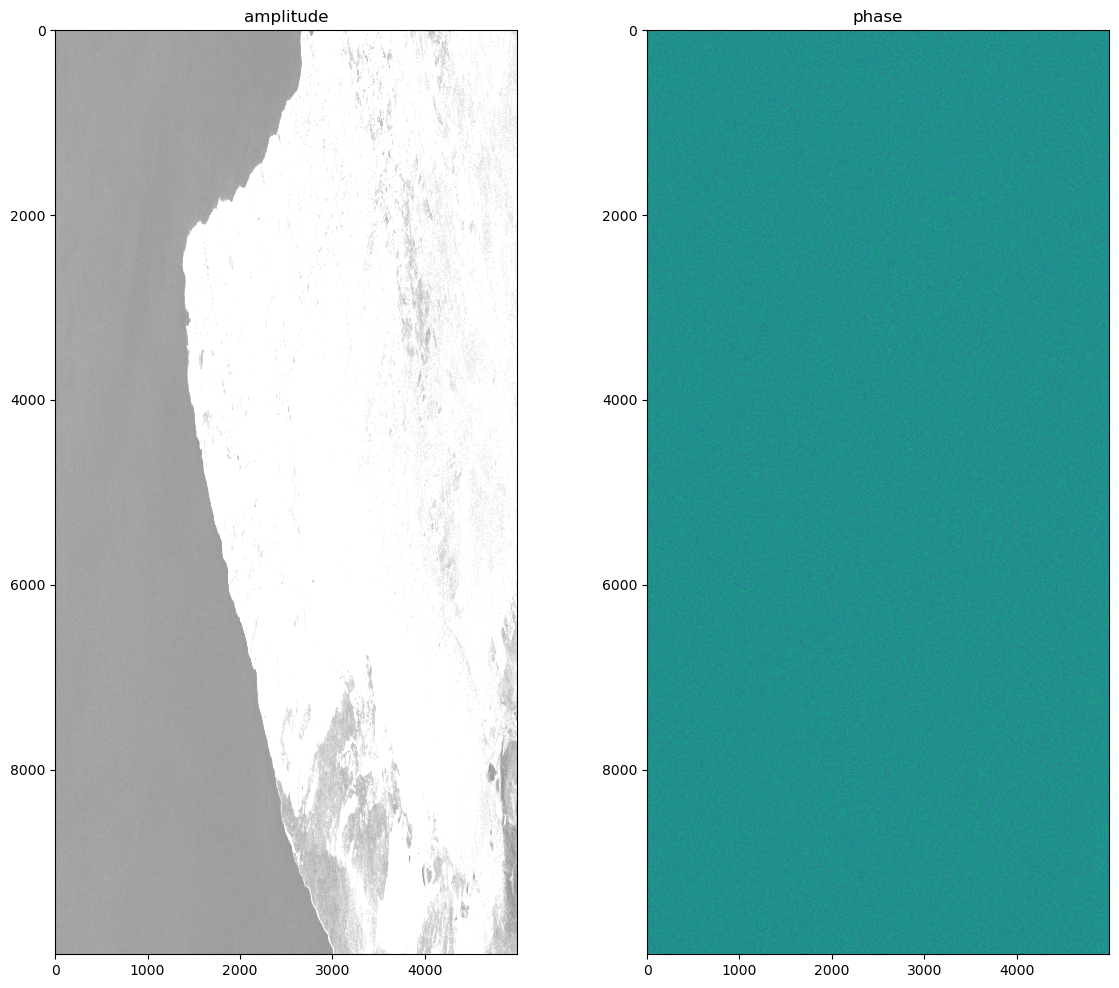

In [22]:

ds = gdal.Open("20110119_slc/20110119.slc", gdal.GA_ReadOnly)
# extract a part of the SLC to display
x0 = 0
y0 = 10000
x_offset = 5000
y_offset = 10000
slc = ds.GetRasterBand(1).ReadAsArray(x0, y0, x_offset, y_offset)
ds = None

fig = plt.figure(figsize=(14, 12))

# display amplitude of the slc
ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(slc), vmin = -2, vmax=2, cmap='gray')
ax.set_title("amplitude")

#display phase of the slc
ax = fig.add_subplot(1,2,2)
ax.imshow(np.angle(slc))
ax.set_title("phase")

plt.show()

slc = None

### crop SLC

In [23]:
!stripmapApp.py stripmapApp.xml  --start=cropslc --end=cropslc

2023-08-05 21:10:25,365 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:10:25,367 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:10:25,390 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step cropslc
No region of interesting provided, skipping cropping of slc data
Dumping the application's pickle object _insar to file  PICKLE/cropslc
The remaining steps are (in order):  ['verifyDEM', 'topo', 'geo2rdr', 'coarse_resample', 'misregistration', 'refined_resample', 'dense_offsets', 'rubber_sheet_range', 'rubber_sheet_azimuth', 'fine_resample', 'split_range_spectrum', 'sub_band_resample', 'interferogram', 'sub_band_interferogram', 'filter', 'filter_low_band', 'filter_high_band', 'unwrap', 'unwrap_low_band

Similar to crop raw data but for SLC. Since region of interest has not been specified, the whole frame is processed.

### verifyDEM

Checks if the DEM was given in the input xml file. If the DEM is not given, then the app downloads SRTM DEM from the NASA Land Processes DAAC.

In [24]:
!stripmapApp.py stripmapApp.xml  --start=verifyDEM --end=verifyDEM

2023-08-05 21:10:26,167 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:10:26,168 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:10:26,191 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step verifyDEM
Polynomial Order: 0 - by - 2 
6.58238	-0.0102063	1.28408e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.44704	-0.00767223	9.40983e-07	
Using native doppler information for bbox estimation
command = curl -n  -L -c $HOME/.earthdatacookie -b $HOME/.earthdatacookie -k -f -O https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/N20W156.SRTMGL1.hgt.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                          

This step will check the DEM file specified in the stripmapApp.xml. If no DEM file has been specified, stripmapApp.py will download the DEM on the fly, mosaic the individual DEM tiles into one file, remove the geoid, and track the filename for subsequent processing. 

<div class="alert alert-danger">
   
<b>POTENTIAL ISSUE:</b> 
You did not set your earthdata credentials as detailed in the ISCE installation. Find instructions here: [Step 2 here](https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget)
</div>

<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
You did set up your earthdata credentials as detailed in the ISCE installation but you have special characters in your password. "Escape" these characters by adding a backslash in front of them. 
</div>

<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
The DEM download site is down and returns no or partial data tiles.
</div></div>  


#### ONLY if download fails

If your DEM download failed and you are unable to resolve the issue, you can use the DEM provided with this tutorial. This requires three steps to complete, before you can rerun the **verifyDEM** step:

1) Copy over the DEM from the backup folder to your processing location

In [25]:
fileZip = ['stripmap_Hawaii.zip']

# zip file with the DEM files
#'demLat_N18_N21_Lon_W157_W154.dem.wgs84',       #Binary raster
#         'demLat_N18_N21_Lon_W157_W154.dem.wgs84.xml',   #XML needed by ISCE
#         'demLat_N18_N21_Lon_W157_W154.dem.wgs84.vrt']   #VRT needed by ISCE

for file in fileZip:
    if not os.path.exists(os.path.join(PROCESS_DIR,file)):
        copy_from_bucket(os.path.join("unavco2022",file),
                 os.path.join(PROCESS_DIR,file))
        print(file + " done")
    else:
        print(file + " already exists")
        
if not os.path.exists(os.path.join(PROCESS_DIR, "stripmap_Hawaii")):
    !unzip stripmap_Hawaii.zip
else:
    print ("stripmap_Hawaii DEM directory already exists")
    !ls stripmap_Hawaii


stripmap_Hawaii.zip done
Archive:  stripmap_Hawaii.zip
   creating: stripmap_Hawaii/
  inflating: stripmap_Hawaii/demLat_N18_N21_Lon_W157_W154.dem.wgs84.xml  
  inflating: stripmap_Hawaii/elevation_COP.dem  
  inflating: stripmap_Hawaii/demLat_N18_N21_Lon_W157_W154.dem.wgs84  
  inflating: stripmap_Hawaii/elevation_COP.dem.vrt  
  inflating: stripmap_Hawaii/elevation_COP.hdr  
  inflating: stripmap_Hawaii/elevation_COP.dem.xml  
  inflating: stripmap_Hawaii/demLat_N18_N21_Lon_W157_W154.dem.wgs84.vrt  


2) To use this DEM, you will need to edit the **stripmapApp.xml** file and uncomment the property for the **demFilename**. You can use the terminal editor `vim` or the built-in Jupyter Lab editor.

``` vim
    vim work/Hawaii_ALOS1/stripmapApp.xml
```

Remember the *xml* guidelines:
```xml
<!--<property> ..COMMENTED.. </property>--> 
<property> ..UNCOMMENTED.. </property>
```
If the staged file name is exactly the same as what `strimapApp.py` was trying to download internally, then the edit may not be necessary, but the unpacked staged files are in a different location in this case.

Now rerun the **verifyDEM** step to ensure the new DEM information is correctly loaded into the processing:

In [26]:
!stripmapApp.py --dostep=verifyDEM

2023-08-05 21:10:53,143 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:10:53,144 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:10:53,166 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step verifyDEM
Polynomial Order: 0 - by - 2 
6.58238	-0.0102063	1.28408e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.44704	-0.00767223	9.40983e-07	
Using native doppler information for bbox estimation
Dumping the application's pickle object _insar to file  PICKLE/verifyDEM
The remaining steps are (in order):  ['topo', 'geo2rdr', 'coarse_resample', 'misregistration', 'refined_resample', 'dense_offsets', 'rubber_sheet_range', 'rubber_sheet_azimuth', 'fine_resample', 'spli

### topo (mapping radar coordinates to geo coordinates)

In [27]:
!stripmapApp.py stripmapApp.xml  --start=topo --end=topo

2023-08-05 21:10:55,020 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:10:55,022 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:10:55,045 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step topo
2023-08-05 21:10:55,193 - isce.insar.runTopo - INFO - Running topo
Polynomial Order: 0 - by - 2 
6.58238	-0.0102063	1.28408e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.44704	-0.00767223	9.40983e-07	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
6.58238	-0.0102063	1.28408e-06	
2023-08-05 21:10:56,451 - isce.zerodop.topozero - WARNING - Default Peg heading set to: -2.92831785566266
Polynomial Order: 0 - by - 1 
948796	9.3685

At this step, based on the SAR acquisition geometry of the reference Image (including Doppler information), platform's trajectory, and an existing DEM providing topography, each pixel of the reference image is geolocated. The geolocated coordinates will be at the same coordinate system of the platforms state vectors, which are usually given in WGS84 coordinate system. Moreover the incidence angle and heading angles will be computed for each pixel. 

![title](notebook_docs/Topo.png)

Outputs of the step "topo" are written to "geometry" directory:


In [28]:
!ls geometry

lat.rdr		  lon.rdr	    los.rdr	      los.rdr.geo.xml
lat.rdr.full	  lon.rdr.full	    los.rdr.full      los.rdr.vrt
lat.rdr.full.vrt  lon.rdr.full.vrt  los.rdr.full.vrt  los.rdr.xml
lat.rdr.full.xml  lon.rdr.full.xml  los.rdr.full.xml  z.rdr.full
lat.rdr.vrt	  lon.rdr.vrt	    los.rdr.geo       z.rdr.full.vrt
lat.rdr.xml	  lon.rdr.xml	    los.rdr.geo.vrt   z.rdr.full.xml


lat.rdr.full: latitude of each pixel on the ground. "full" stands for full SAR image resolution grid (before multi-looking)

lon.rdr.full: longitude

z.rdr.full: height

los.rdr.full: incidence angle and heading angle

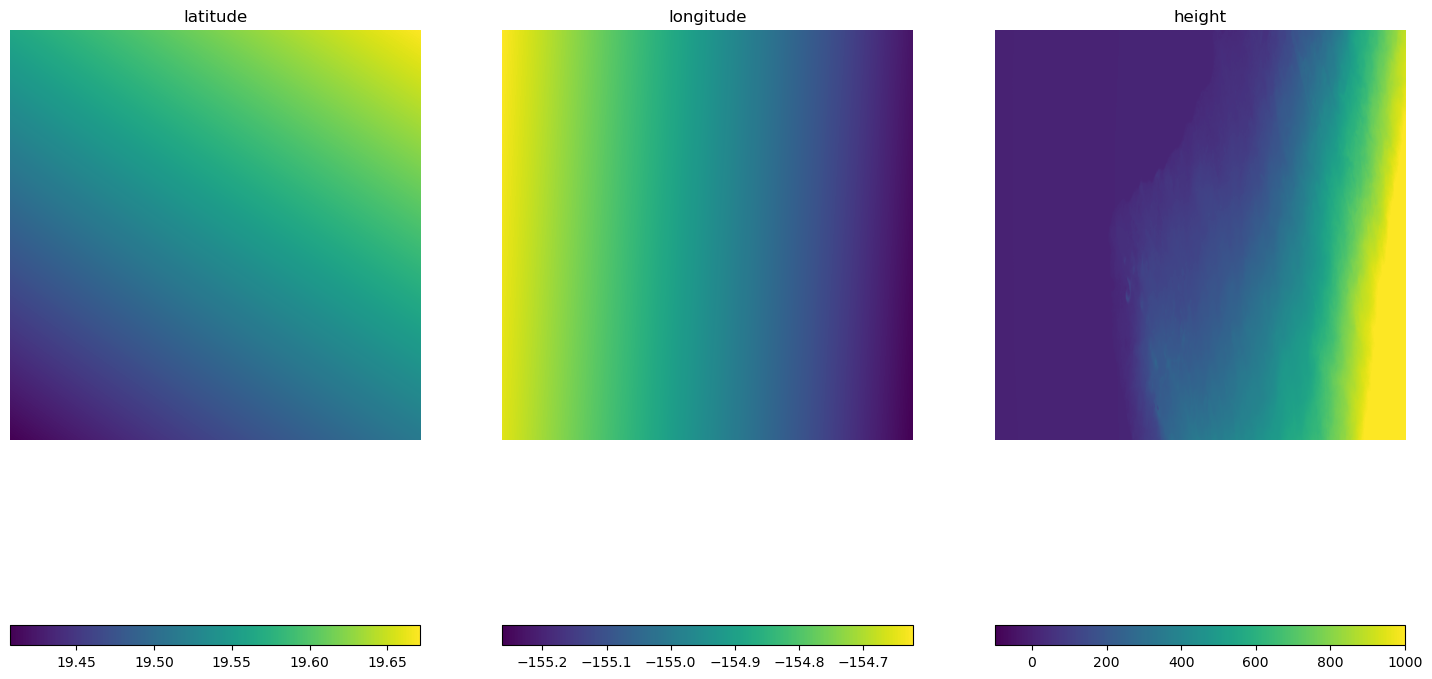

In [29]:
# Read a bounding box of latitude
ds = gdal.Open('geometry/lat.rdr.full', gdal.GA_ReadOnly)
lat = ds.GetRasterBand(1).ReadAsArray(0,10000,5000, 5000)
ds = None

# Read a bounding box of longitude
ds = gdal.Open('geometry/lon.rdr.full', gdal.GA_ReadOnly)
lon = ds.GetRasterBand(1).ReadAsArray(0,10000,5000, 5000)
ds = None

# Read a bounding box of height
ds = gdal.Open('geometry/z.rdr.full', gdal.GA_ReadOnly)
hgt = ds.GetRasterBand(1).ReadAsArray(0,10000,5000, 5000)
ds = None

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
cax=ax.imshow(lat)
ax.set_title("latitude")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')


ax = fig.add_subplot(1,3,2)
cax=ax.imshow(lon)
ax.set_title("longitude")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')


ax = fig.add_subplot(1,3,3)
cax=ax.imshow(hgt, vmin = -100, vmax=1000)
ax.set_title("height")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')

plt.show()

lat = None
lon = None
hgt = None

### geo2rdr (mapping from geo coordinates to radar coordinates)

In [30]:
!stripmapApp.py stripmapApp.xml --start=geo2rdr --end=geo2rdr

2023-08-05 21:16:15,587 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:16:15,589 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:16:15,612 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step geo2rdr
2023-08-05 21:16:15,757 - isce.insar.runGeo2rdr - INFO - Running geo2rdr
Turning off bistatic delay correction term by default.
API open (WR): offsets/range.off
API open (WR): offsets/azimuth.off
GDAL open (R): geometry/z.rdr.full.vrt
GDAL open (R): geometry/lat.rdr.full.vrt
GDAL open (R): geometry/lon.rdr.full.vrt
 Orbit interpolation method: hermite
 threads           8
 Starting Acquisition time:    73956.186790000007     
 Stop Acquisition time:    73970.590877000010     
 Azimuth line spacing in s

At this step, given the geo-coordinates of each pixel in the reference image (outputs of topo), the range and azimuth time (radar coordinates) is computed given the acquisition geometry and orbit information of the secondary image.  

![title](notebook_docs/Geo2rdr.png)

The computed range and azimuth time for the secondary image, gives the pure geometrical offset of the secondary image from the reference, required for resampling the secondary image to the reference image in the next step.

![title](notebook_docs/deltaR.png)

After running this step, the geometrical offsets are available in "offsets" folder:

In [31]:
!ls offsets

azimuth.off	 azimuth.off.xml  range.off.vrt
azimuth.off.vrt  range.off	  range.off.xml


azimuth.off: contains the geometric offsets between reference and secondary images in azimuth direction

range.off:   contains the geometric offsets between reference and secondary images in range direction

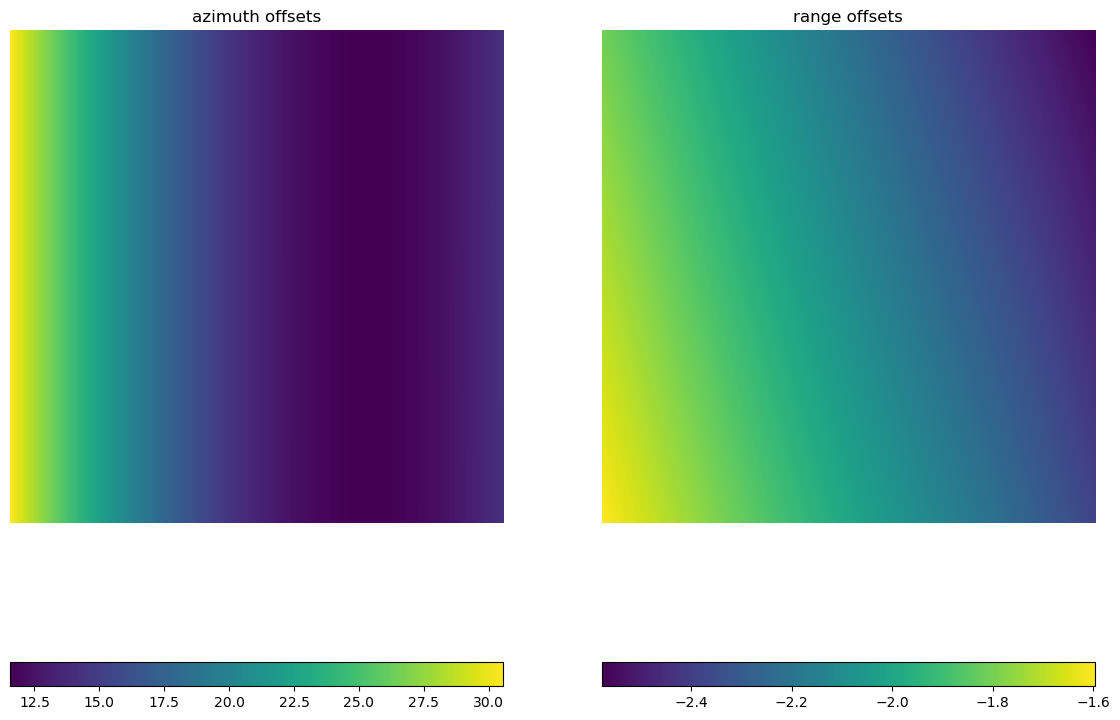

In [32]:
from osgeo import gdal
import matplotlib.pyplot as plt

ds = gdal.Open('offsets/azimuth.off', gdal.GA_ReadOnly)
# extract only part of the data to display
az_offsets = ds.GetRasterBand(1).ReadAsArray(100,100,5000,5000)
ds = None

ds = gdal.Open('offsets/range.off', gdal.GA_ReadOnly)
# extract only part of the data to display
rng_offsets = ds.GetRasterBand(1).ReadAsArray(100,100,5000,5000)
ds = None

fig = plt.figure(figsize=(14, 12))

ax = fig.add_subplot(1,2,1)
cax=ax.imshow(az_offsets)
ax.set_title("azimuth offsets")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')

ax = fig.add_subplot(1,2,2)
cax = ax.imshow(rng_offsets)
ax.set_title("range offsets")
ax.set_axis_off()
cbar = fig.colorbar(cax, orientation='horizontal')

plt.show()

az_offsets = None
rng_offsets = None

### resampling (using only geometrical offsets)

In [33]:
!stripmapApp.py stripmapApp.xml --start=coarse_resample --end=coarse_resample

2023-08-05 21:19:05,000 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:19:05,002 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:19:05,024 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step coarse_resample
2023-08-05 21:19:05,169 - isce.insar.runResampleSlc - INFO - Resampling secondary SLC
Polynomial Order: 0 - by - 2 
-0.0243782	-2.51153e-05	3.08035e-09	
misreg/misreg  does not exist.
2023-08-05 21:19:05,352 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_LINES has been set to the default value 27648 which is the number of lines in the slc image.
2023-08-05 21:19:05,352 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_WIDTH has been set to the default value 5562 which is the wi

At this step, the gemetrical offsets are used to resample the secondary image to the same grid as the reference image, i.e., the secondary image is approximately co-registered to the reference image. The output of this step is written to "coregisteredSlc" folder.

In [34]:
!ls coregisteredSlc/

coarse_coreg.slc      highBand		 refined_coreg.slc.vrt
coarse_coreg.slc.vrt  lowBand		 refined_coreg.slc.xml
coarse_coreg.slc.xml  refined_coreg.slc


coarse_coreg.slc: is the secondary SLC coregistered to the reference image

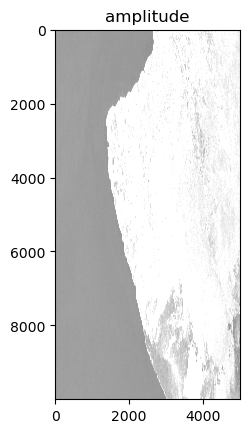

In [35]:
from osgeo import gdal

ds = gdal.Open("coregisteredSlc/coarse_coreg.slc", gdal.GA_ReadOnly)
slc = ds.GetRasterBand(1).ReadAsArray(0, 10000, 5000, 10000)
ds = None

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(slc), vmin = -2, vmax=2, cmap='gray')
ax.set_title("amplitude")

slc = None

### misregistration (estimating constant offsets in range and azimuth directions)

In [36]:
!stripmapApp.py stripmapApp.xml --start=misregistration --end=misregistration

2023-08-05 21:20:35,588 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:20:35,589 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:20:35,613 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step misregistration
2023-08-05 21:20:35,758 - isce.insar.runRefineSecondaryTiming - INFO - Running refine secondary timing
GDAL open (R): coregisteredSlc/coarse_coreg.slc.vrt
GDAL open (R): 20110119_slc/20110119.slc.vrt
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 687
Skip Sample Across: 121
 Input Bands:            1           1
  XXX start timer
 wisdomFile, length =            0
 WARNING - number of samples availabe for estating gross offset is NOT power of 2:          80
        

The range and azimuth offsets derived from pure geometry can be potentially affected by inaccuracy of orbit information or inaccurate DEMs, or inaccurate SAR metadata. Coregistration can also be affected by changes in the ionosphere, especially for L-band data like this ALOS data The current available DEMs (e.g., SRTM DEMs) are accurate enough to estimate offsets with accuracies of 1/100 of a pixel. The Orbit information of most modern SAR sensors are also precise enough to obtain the same order of accuracy. However, inaccurate metadata (such as timing error, constant range bias), or range bulk delay by the ionosphere may affect the estimated offsets. To account for such sources of errors the misregistration step is performed to estimate possible constant offsets between coarse coregistered SLC and reference SLC. For this purpose an incoherent cross correlation is performed and the average offset over the whole scene is estimated. 

The results of the "misregistration" step is written to the "misreg" folder.


In [37]:
!ls misreg/

misreg_az.xml  misreg.bak  misreg.dat  misreg.dir  misreg_rg.xml


In order to extract the estimated misregistration offsets we can use the ISCE internal objects to load the information saved in the XML files:

In [38]:
import isce
import isceobj.StripmapProc.StripmapProc as St

stObj=St()
stObj.configure()

az = stObj.loadProduct("misreg/misreg_az.xml")
rng = stObj.loadProduct("misreg/misreg_rg.xml")

print("azimuth misregistration: ", az._coeffs)
print("range misregistration: ", rng._coeffs)

azimuth misregistration:  [[0.4464050049162751]]
range misregistration:  [[0.9900457887755089]]


For this pair, there is a range misregistration of 0.99 pixels or about 9 meters.

### refine_resample (resampling using geometrical offsets + misregistration)

In [39]:
!stripmapApp.py stripmapApp.xml --start=refined_resample --end=refined_resample

2023-08-05 21:25:17,044 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:25:17,046 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:25:17,069 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step refined_resample
2023-08-05 21:25:17,214 - isce.insar.runResampleSlc - INFO - Resampling secondary SLC
Polynomial Order: 0 - by - 2 
-0.0243782	-2.51153e-05	3.08035e-09	
2023-08-05 21:25:17,400 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_LINES has been set to the default value 27648 which is the number of lines in the slc image.
2023-08-05 21:25:17,400 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_WIDTH has been set to the default value 5562 which is the width of the slc image.
GDAL ope

At this step resampling is re-run to account for the misregistration estimated at the previous step. The new coregisterd SLC (named refined_coreg.slc) is written to the "coregisteredSlc" folder.

In [40]:
!ls coregisteredSlc/

coarse_coreg.slc      highBand		 refined_coreg.slc.vrt
coarse_coreg.slc.vrt  lowBand		 refined_coreg.slc.xml
coarse_coreg.slc.xml  refined_coreg.slc


### optional steps ('dense_offsets', 'rubber_sheet', 'fine_resample', 'split_range_spectrum' , 'sub_band_resample')

In [41]:
!stripmapApp.py stripmapApp.xml --start=dense_offsets --end=sub_band_resample

2023-08-05 21:26:47,259 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:26:47,261 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:26:47,284 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step dense_offsets
Dumping the application's pickle object _insar to file  PICKLE/dense_offsets
The remaining steps are (in order):  ['rubber_sheet_range', 'rubber_sheet_azimuth', 'fine_resample', 'split_range_spectrum', 'sub_band_resample', 'interferogram', 'sub_band_interferogram', 'filter', 'filter_low_band', 'filter_high_band', 'unwrap', 'unwrap_low_band', 'unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']
Running step rubber_sheet_range
Rubber sheeting in azimuth not requested ... skipping

These steps are optional and will be skipped if user does not request them in the input xml file. We will get back to these steps in a different session where we estimate ionospheric phase.

### interferogram

Now we are finally ready to calculate the interferogram between the two precisely coregistered SLC images.

In [42]:
!stripmapApp.py stripmapApp.xml --start=interferogram --end=interferogram

2023-08-05 21:26:48,080 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:26:48,081 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:26:48,105 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step interferogram
2023-08-05 21:26:48,251 - isce.insar.runInterferogram - INFO - igramSpectrum = full
2023-08-05 21:26:48,251 - isce.insar.runInterferogram - INFO - Generating interferogram
incidence angle at the middle of the swath:  47.40596655633679
Ground range resolution at the middle of the swath:  14.544071121391305
azimuth and range looks:  8 2
2023-08-05 21:26:48,363 - isce.insar.runInterferogram - INFO - Interferogram directory interferogram already exists.
GDAL open (R): 20110119_slc/20110119.slc.vrt
GD

At this step the reference SLC image and refined_coreg.slc is used to generate the interferogram. The generated interferogram is multi-looked based on the user inputs in the input xml file. If user does not specify the number of looks in range and azimuth directions, then they will be estimated based on posting. The default posting is 30 m which can be also specified in the input xml file.

The results of the interferogram step is written to the "interferogram" folder:

In [43]:
!ls interferogram/

filt_topophase.conncomp      filt_topophase.unw.xml  topophase.cor.full.vrt
filt_topophase.conncomp.vrt  highBand		     topophase.cor.full.xml
filt_topophase.conncomp.xml  lowBand		     topophase.cor.geo
filt_topophase.flat	     phsig.cor		     topophase.cor.geo.vrt
filt_topophase.flat.geo      phsig.cor.geo	     topophase.cor.geo.xml
filt_topophase.flat.geo.vrt  phsig.cor.geo.vrt	     topophase.cor.vrt
filt_topophase.flat.geo.xml  phsig.cor.geo.xml	     topophase.cor.xml
filt_topophase.flat.vrt      phsig.cor.vrt	     topophase.flat
filt_topophase.flat.xml      phsig.cor.xml	     topophase.flat.geo
filt_topophase.unw	     topophase.amp	     topophase.flat.geo.vrt
filt_topophase.unw.geo	     topophase.amp.vrt	     topophase.flat.geo.xml
filt_topophase.unw.geo.vrt   topophase.amp.xml	     topophase.flat.vrt
filt_topophase.unw.geo.xml   topophase.cor	     topophase.flat.xml
filt_topophase.unw.vrt	     topophase.cor.full


topophase.flat: flattened (geometrical phase removed) and multi-looked interferogram.(one band complex64 data).

topophase.cor: coherence and magnitude for the flattened multi-looked interferogram. (two bands float32 data).

topophase.cor.full: similar to topophase.cor but at full SAR resolution.

topophase.amp: amplitudes of reference amd secondary images. (two bands float32) 


### sub-band interferogram

In [44]:
!stripmapApp.py stripmapApp.xml --start=sub_band_interferogram --end=sub_band_interferogram

2023-08-05 21:29:25,911 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:29:25,913 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:29:25,937 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step sub_band_interferogram
2023-08-05 21:29:26,085 - isce.insar.runInterferogram - INFO - igramSpectrum = sub
Estimating dispersive phase not requested ... skipping sub-band interferograms
Dumping the application's pickle object _insar to file  PICKLE/sub_band_interferogram
The remaining steps are (in order):  ['filter', 'filter_low_band', 'filter_high_band', 'unwrap', 'unwrap_low_band', 'unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']


This step will be skipped as we have not asked for ionospheric phase estimation. We will get back to this step in the ionospheric phase estimation notebook.

### filter

In [45]:
!stripmapApp.py stripmapApp.xml --start=filter --end=filter

2023-08-05 21:29:26,718 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:29:26,720 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:29:26,743 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step filter
2023-08-05 21:29:26,890 - isce.insar.runFilter - INFO - Applying power-spectral filter
2023-08-05 21:29:26,890 - isce.insar.runFilter - INFO - Filtering the full-band interferogram
GDAL open (R): interferogram/topophase.flat.vrt
API open (WR): interferogram/filt_topophase.flat
2023-08-05 21:29:26,904 - isce.mroipac.filter - DEBUG - width: 2781
2023-08-05 21:29:26,904 - isce.mroipac.filter - DEBUG - length: 3456
2023-08-05 21:29:26,904 - isce.mroipac.filter - DEBUG - input: interferogram/topophase.flat
2

A power spectrum filter (Goldstein and Werner, 1998) is applied to the multi-looked interferogram to reduce noise.

Now we can display the interferogram before and after the filtering and see the ground displacement signals in this interferogram.

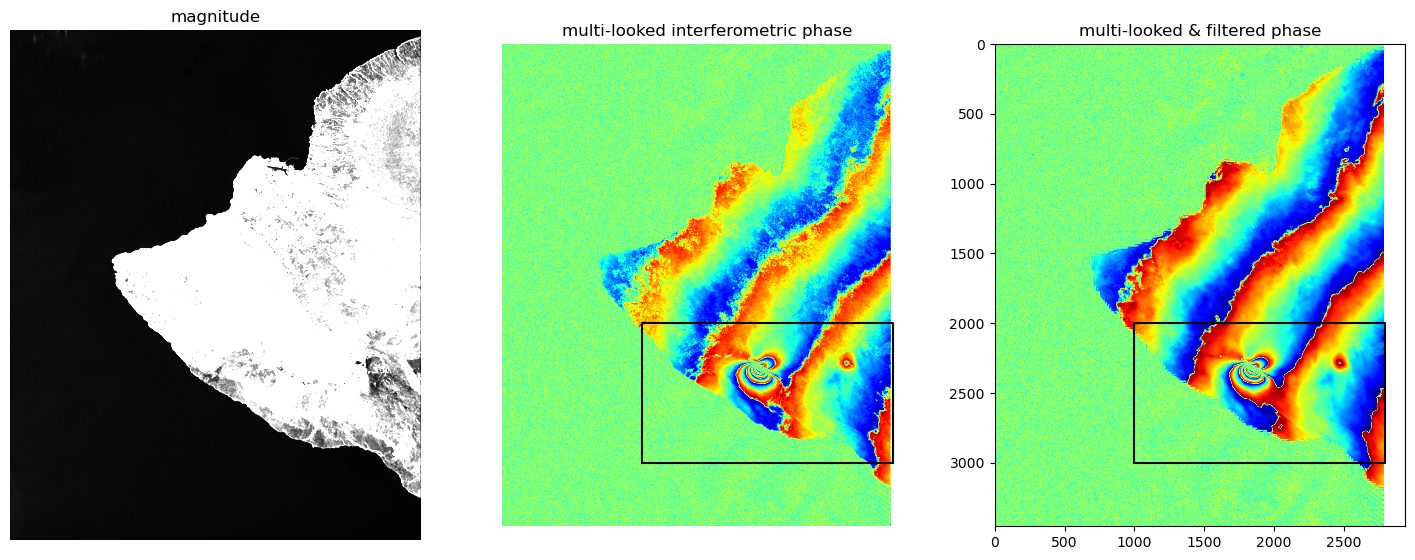

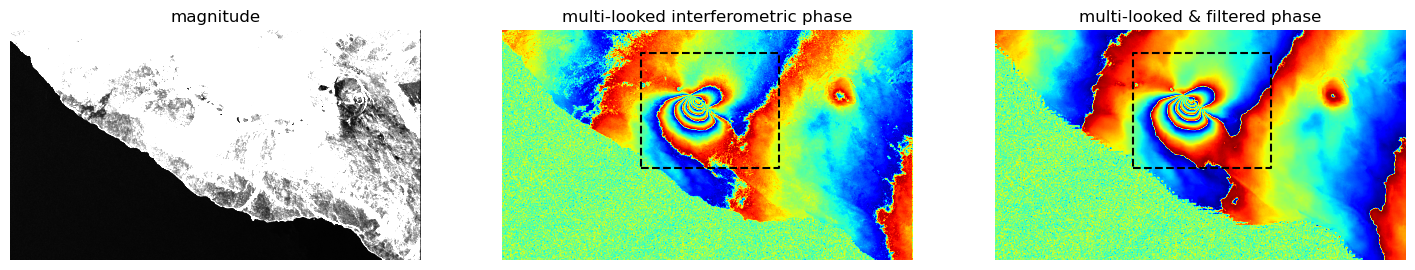

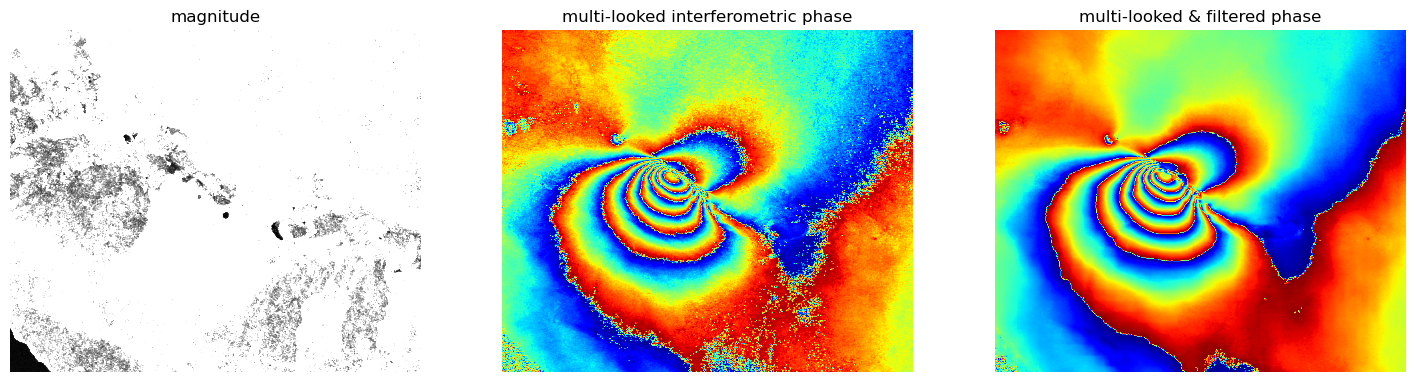

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# reading the multi-looked wrapped interferogram
ds = gdal.Open("interferogram/topophase.flat", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

# reading the multi-looked un-wrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.flat", gdal.GA_ReadOnly)
filt_igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(np.abs(igram), vmin = 0 , vmax = 60.0, cmap = 'gray')
ax.set_title("magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(np.angle(igram), cmap='jet')
ax.plot([1000,2800,2800,1000,1000],[3000,3000,2000,2000,3000],'-k')
ax.set_title("multi-looked interferometric phase")
ax.set_axis_off()

ax = fig.add_subplot(1,3,3)
ax.imshow(np.angle(filt_igram), cmap='jet')
ax.plot([1000,2800,2800,1000,1000],[3000,3000,2000,2000,3000],'-k')
ax.set_title("multi-looked & filtered phase")
#ax.set_axis_off()

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(np.abs(igram[2000:3000, 1000:2800]), vmin = 0 , vmax = 60.0, cmap = 'gray')
ax.set_title("magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(np.angle(igram[2000:3000, 1000:2800]), cmap='jet')
ax.plot([600,1200,1200,600,600],[600,600,100,100,600],'--k')
ax.set_title("multi-looked interferometric phase")
ax.set_axis_off()

ax = fig.add_subplot(1,3,3)
ax.imshow(np.angle(filt_igram[2000:3000, 1000:2800]), cmap='jet')
ax.plot([600,1200,1200,600,600],[600,600,100,100,600],'--k')
ax.set_title("multi-looked & filtered phase")
ax.set_axis_off()

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(np.abs(igram[2100:2600, 1600:2200]), vmin = 0 , vmax = 60.0, cmap = 'gray')
ax.set_title("magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(np.angle(igram[2100:2600, 1600:2200]), cmap='jet')
ax.set_title("multi-looked interferometric phase")
ax.set_axis_off()

ax = fig.add_subplot(1,3,3)
ax.imshow(np.angle(filt_igram[2100:2600, 1600:2200]), cmap='jet')
ax.set_title("multi-looked & filtered phase")
ax.set_axis_off()

filt_igram = None
igram = None


<br>
<div class="alert alert-info">
<b>Note :</b> 
The interferometric phase, shows ground displacement caused by dike opening event in March 2011, along the east rift zone of Kīlauea Volcano, Hawaii. There is also some subsidence at the summit of Kīlauea due to magma withdrawal.
<br>
The overall ramp of fringes across the scene is due to the ionospheric variations that we will discuss later.
</div>


### optional steps ('filter_low_band', 'filter_high_band')

In [47]:
!stripmapApp.py stripmapApp.xml --start=filter_low_band  --end=filter_high_band

2023-08-05 21:30:03,135 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:30:03,137 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:30:03,160 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step filter_low_band
2023-08-05 21:30:03,307 - isce.insar.runFilter - INFO - Applying power-spectral filter
Estimating dispersive phase not requested ... skipping sub-band interferograms
Dumping the application's pickle object _insar to file  PICKLE/filter_low_band
The remaining steps are (in order):  ['filter_high_band', 'unwrap', 'unwrap_low_band', 'unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']
Running step filter_high_band
2023-08-05 21:30:03,312 - isce.insar.runFilter - INFO - Applying 

These steps will be skipped since we have not asked for ionospheric phase estimation in the input xml file.

### unwrap

In [48]:
!stripmapApp.py stripmapApp.xml --start=unwrap  --end=unwrap

2023-08-05 21:30:03,948 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:30:03,950 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:30:03,974 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step unwrap
GDAL open (R): interferogram/topophase.amp.vrt
GDAL open (R): interferogram/filt_topophase.flat.vrt
API open (WR): interferogram/filt_topophase.unw
API open (WR): interferogram/filt_topophase.conncomp

 << PS filtering >>


 interferogram width:  2781  number of lines/patch:  3656
 start line:        1  number of lines:    3456
 start sample:      1  end sample:         2781
 wisdomFile, length =            0

 << Unwrapping with icu, random trees 3-Nov-98 CW/PAR/SH >>

 Branch Cut Tree Type:           

At this step the wrapped phase of the filtered and multi-looked interferogram is unwrapped in radar coordinates. The unwrapped interferogram is a two band data with magnitude and phase components.

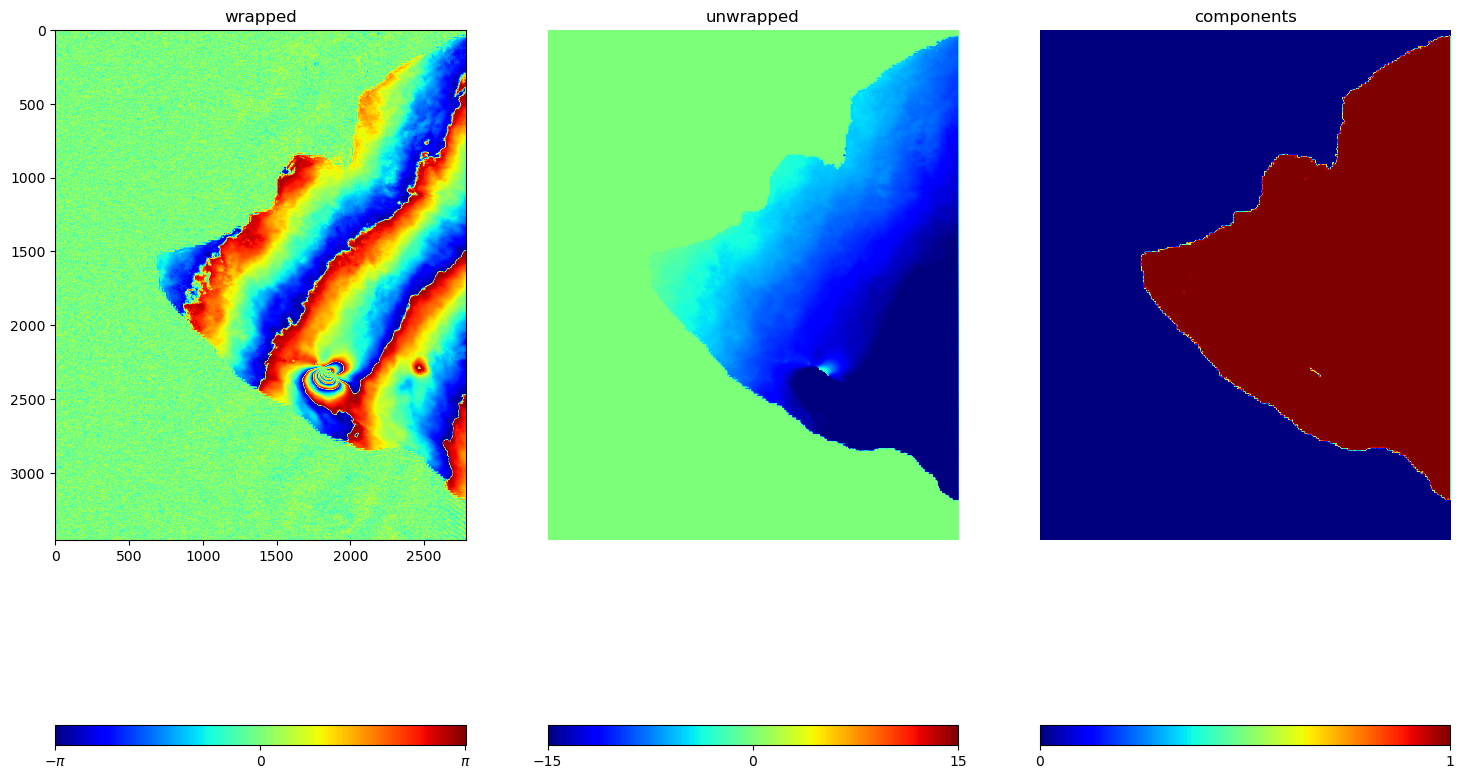

In [49]:
import matplotlib.pyplot as plt

# reading the multi-looked wrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.flat", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

# reading the multi-looked unwrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.unw", gdal.GA_ReadOnly)
igram_unw = ds.GetRasterBand(2).ReadAsArray()
ds = None

# reading the connected component file
ds = gdal.Open("interferogram/filt_topophase.conncomp", gdal.GA_ReadOnly)
connected_components = ds.GetRasterBand(1).ReadAsArray()
ds = None


fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
cax=ax.imshow(np.angle(igram), cmap='jet')
ax.set_title("wrapped")
#ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-3.14,0,3.14],orientation='horizontal')
cbar.ax.set_xticklabels(["$-\pi$",0,"$\pi$"])

ax = fig.add_subplot(1,3,2)
cax = ax.imshow(igram_unw, vmin = -15 , vmax = 15.0, cmap = 'jet')
ax.set_title("unwrapped")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-15,0, 15], orientation='horizontal')


ax = fig.add_subplot(1,3,3)
cax = ax.imshow(connected_components, cmap = 'jet')
ax.set_title("components")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[0, 1] , orientation='horizontal')
cbar.ax.set_xticklabels([0,1])


connected_components = None

<br>
<div class="alert alert-info">
<b>Note (wrapped vs unwrapped) :</b> 
Note the colorscale for the wrapped and unwrapped interferograms. The wrapped interferometric phase varies from $-\pi$ to $\pi$, while the unwrapped interferogram varies from -15 to 15 radians.
</div>

<br>
<div class="alert alert-info">
<b>Note :</b> 
The connected components file is a product of the phase unwrapping. Each interferogram may have several connected compoenets. The unwrapped phase within each component is expected to be correctly unwrapped. However, there might be $2\pi$ phase jumps between the components. Advanced ISCE users may use the 2-stage unwrapping to adjust ambiguities among different components. stripmapApp currently does not support 2-stage unwrapping. Look for this option in future releases.  
</div>


We can look at profiles of the phase in the wrapped and unwrapped interferograms. The first profile is a small distance where the phase does not vary more than 2-pi. The second profile is a longer profile that shows the effects of the phase unwrapping required when the phase varies by more than 2-pi.

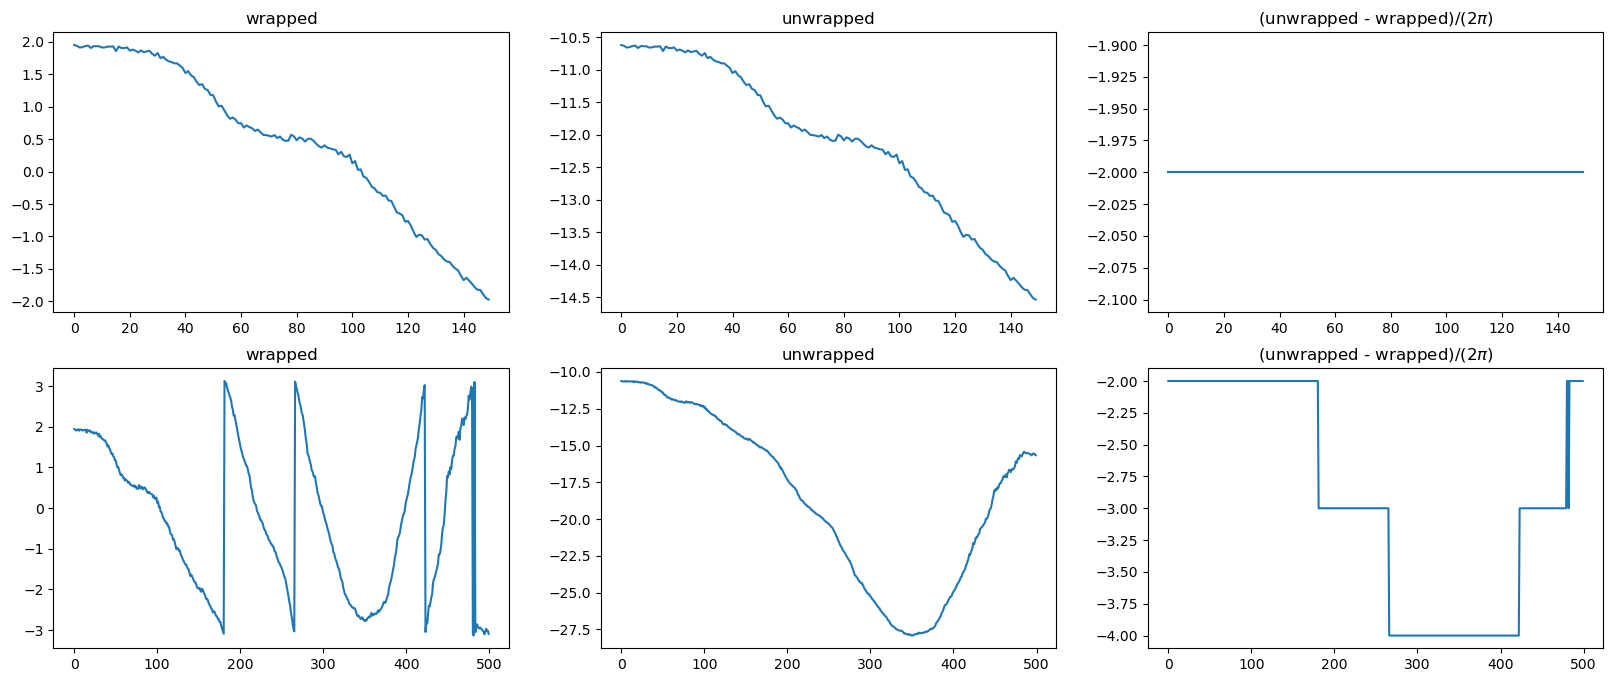

In [50]:

profile_wrapped_1 = np.angle(igram[2400,1500:1650])
profile_unwrapped_1 = igram_unw[2400,1500:1650]
profile_wrapped_2 = np.angle(igram[2400,1500:2000])
profile_unwrapped_2 = igram_unw[2400,1500:2000]

fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(2,3,1)
cax=ax.plot(profile_wrapped_1)
ax.set_title("wrapped")

ax = fig.add_subplot(2,3,2)
cax=ax.plot(profile_unwrapped_1)
ax.set_title("unwrapped")

ax = fig.add_subplot(2,3,3)
cax=ax.plot(np.round((profile_unwrapped_1-profile_wrapped_1)/2.0/np.pi))
ax.set_title("(unwrapped - wrapped)/(2$\pi$)")

ax = fig.add_subplot(2,3,4)
cax=ax.plot(profile_wrapped_2)
ax.set_title("wrapped")

ax = fig.add_subplot(2,3,5)
cax=ax.plot(profile_unwrapped_2)
ax.set_title("unwrapped")

ax = fig.add_subplot(2,3,6)
cax=ax.plot((profile_unwrapped_2-profile_wrapped_2)/2.0/np.pi)
ax.set_title("(unwrapped - wrapped)/(2$\pi$)")


igram = None
igram_unw = None

### optional steps ('unwrap_low_band', 'unwrap_high_band', 'ionosphere')

In [51]:
!stripmapApp.py stripmapApp.xml --start=unwrap_low_band  --end=ionosphere

2023-08-05 21:31:16,178 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:31:16,179 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:31:16,202 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step unwrap_low_band
Estimating dispersive phase not requested ... skipping sub-band interferogram unwrapping
Dumping the application's pickle object _insar to file  PICKLE/unwrap_low_band
The remaining steps are (in order):  ['unwrap_high_band', 'ionosphere', 'geocode', 'geocodeoffsets', 'endup']
Running step unwrap_high_band
Estimating dispersive phase not requested ... skipping sub-band interferogram unwrapping
Dumping the application's pickle object _insar to file  PICKLE/unwrap_high_band
The remaining steps ar

Since we have not asked for ionospheric phase estimation, all these steps will be skipped.

### geocoding

Now we can geocode the interferogram and put it into the geographic coordinates that can be combined with other datasets.

In [52]:
!stripmapApp.py stripmapApp.xml --start=geocode  --end=geocode

2023-08-05 21:31:16,989 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-05 21:31:16,991 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-05 21:31:17,013 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step geocode
2023-08-05 21:31:17,159 - isce.topsinsar.runGeocode - INFO - Geocoding Image
Number of products to geocode:  9
incidence angle at the middle of the swath:  47.40596655633679
Ground range resolution at the middle of the swath:  14.544071121391305
Polynomial Order: 0 - by - 2 
6.58238	-0.0102063	1.28408e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.44704	-0.00767223	9.40983e-07	
Using native doppler information for bbox estimation
Output:  interferogram/topoph

## Final Geocoded Unwrapped phase
Now we can plot the geocoded unwrapped phase that is sometimes called a GUNW product. We will work with the GRFN ARIA-processed Sentinel-1 GUNW products later in the course.

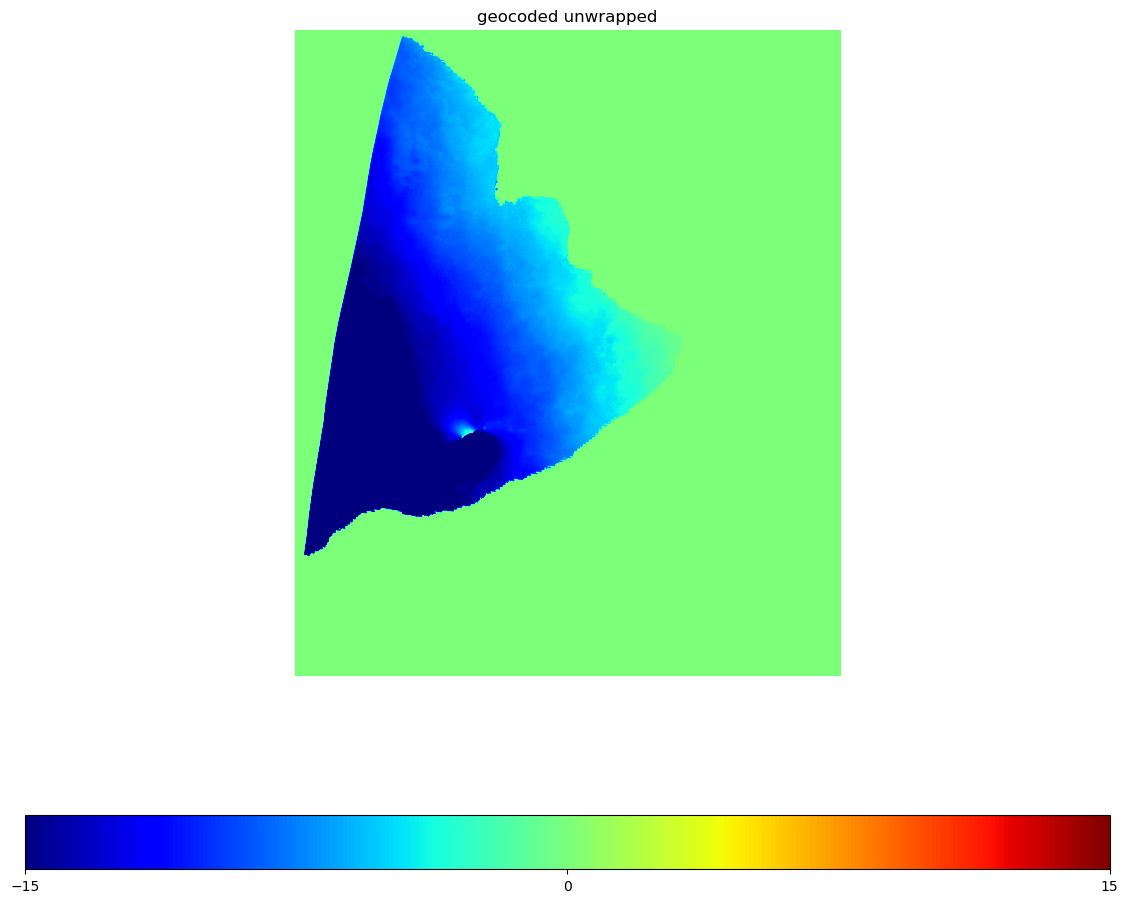

In [53]:
# reading the multi-looked wrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.unw.geo", gdal.GA_ReadOnly)
unw_geocoded = ds.GetRasterBand(2).ReadAsArray()
ds = None


fig = plt.figure(figsize=(14,12))

ax = fig.add_subplot(1,1,1)
cax = ax.imshow(unw_geocoded, vmin = -15 , vmax = 15.0, cmap = 'jet')
ax.set_title("geocoded unwrapped")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-15,0, 15], orientation='horizontal')

plt.show()
unw_geocoded = None

The dike injection signal is partly hidden by the large phase ramp across the scene that is caused by ionospheric variations in this L-band pair.

# Supplementary Information

### understanding xml files

The format of this type of file may seem unfamiliar or strange to you, but with the following description of the basics of the format, it will hopefully become more familiar.   The first thing to point out is that the indentations and line breaks seen above are not required and are simply used to make the structure more clear and the file more readable to humans.  The xml file provides structure to data for consumption by a computer.  As far as the computer is concerned the data structure is equally readable if all of the information were contained on a single very long line, but human readers would have a hard time reading it in that format. 

The next thing to point out is the method by which the data are structured through the use of tags and attributes.  An item enclosed in the < (less-than) and > (greater-than) symbols is referred to as a tag.  The name enclosed in the < and > symbols is the name of the tag.  Every tag in an xml file must have an associated closing tag that contains the same name but starts with the symbol </ and ends with the symbol >.  This is the basic unit of structure given to the data.  Data are enclosed inside of opening and closing tags that have names identifying the enclosed data.  This structure is nested to any order of nesting necessary to represent the data.  The Python language (in which the ISCE user interface is written) provides powerful tools to parse the xml structure into a data structure object and to very easily “walk” through the structure of that object.  

In the above xml file the first and last tags in the file are a tag pair: <stripmapApp> and </stripmapApp> (note again, tags must come in pairs like this).  The first of these two tags, or the opening tag,  marks the beginning of the contents of the tag and the second of these two tags, or the closing tag, marks the end of the contents of the tag.  ISCE expects a “file tag” of this nature to bracket all inputs contained in the file.  The actual name of the file tag, as far as ISCE is concerned, is user selectable.  In this example it is used, as a convenience to the user, to document the ISCE application, named insarApp.py, for which it is meant to provide inputs; it could have been named <foo> and insarApp.py would have been equally happy provided that the closing tag were </foo>.  

The next tag  is <component name="insar">.  Its closing tag </component> is located at the penultimate line of the file (one line above the </insar> tag). The name of this tag is component and it has an attribute called name with value “insarApp”. The component tags bound a collection of information that is used by a computational element within ISCE that has the name specified by the name attribute.   The name “insarApp”  in the first component tag tells ISCE that the enclosed information correspond to a functional component in ISCE named “insarApp”, which in this case is actually the application that is run at the command line.  

In general, component tags contain information in the form of other component tags or property tags, all of which can be nested to any required level. In this example the  insarApp component contains a property tag and two other component tags.

The first tag we see in the insarApp component tag is the property tag with attribute name=“sensor name”. The property tag contains a value tag that contains the name of the sensor, ALOS in this case.  The next tag is a component tag with attribute name=”reference”. This tag contains a catalog tag containing  reference.xml.  The catalog tag in general informs ISCE to look in the named file (reference.xml in this case) for the contents of the current tag.  The next component tag has the same structure with the catalog  tag containing a different file named secondary.xml.

### Extra configuration parameters 

The input configuration file in this tutorial only included mandatory parameters including the reference and secondary images, which are enough to run the application. This means that the application is configured with default parameters hardwired in the code or computed during processing. 
For custom processing, user may want to set parameters in the input configuration file. In the following a few more parameters are shown that can be added to stripmapApp.xml. 

### regionOfInterest

To specify a region of interest to process:

```xml
<property name="regionOfInterest">[South, North, West, East]</property>
```

Example: 

```xml
<property name="regionOfInterest">[19.0, 19.9, -155.4, -154.7]</property>
```

Default: Full frame is processed.

### range looks
number of looks in range direction 

```xml
<property name="range looks">USER_INPUT</property>
```

Deafult: is computed based on the posting parameter.

### azimuth looks
number of looks in azimuth direction 

Deafult: is computed based on the posting parameter.


### posting
Interferogram posting in meters.

```xml
<property name="posting">USER_INPUT</property>
```

Default: 30

<br>
<div class="alert alert-info">
<b>Note :</b> 
If "range looks" and "azimuth looks" have not been specified, then posting is used to compute them such that the interferogram is generated with a roughly square pixels size with each dimension close to the "posting" parameter.

</div>

### filter strength

strength of the adaptive filter used for filtering the wrapped interferogram

```xml
<property name="filter strength">USER_INPUT</property>
```

Default: 0.5


### useHighResolutionDemOnly
```xml
<property name="useHighResolutionDemOnly">True</property>
```

If True and a dem is not specified in input, it will only
    download the SRTM highest resolution dem if it is available
    and fill the missing portion with null values (typically -32767)

Default: False

### do unwrap

To turn phase unwrapping off
```xml
<property name="do unwrap">False</property>
```

Default: True


### unwrapper name
To choose the name of the phase unwrapping method. e.g., to choose "snaphu" for phase unwrapping
```xml
<property name="unwrapper name">snaphu</property>
```

Default: "icu".




### do rubbersheeting

To turn on rubbersheeting (estimating azimuth offsets caused by strong ionospheric scentilation)

```xml
<property name="do rubbersheeting">True</property>
```
Default : False

### rubber sheet SNR Threshold

```xml
<property name="rubber sheet SNR Threshold">USER_INPUT</property>
```
If "do rubbersheeting" is turned on, then this values is used to mask out azimuth offsets with SNR less that the input threshold. 

Default: 5

### rubber sheet filter size
the size of the median filter used for filtering the azimuth offsets

```xml
<property name="rubber sheet filter size">USER_INPUT</property>
```

Default: 8

### do denseoffsets
turn on the dense offsets computation from cross correlation

```xml
<property name="do denseoffsets">True</property>
```

Default: False

<br>
<div class="alert alert-info">
<b>Note :</b> 

If "do rubbersheeting" is turned on, then dense offsets computation is turned on regardless of the user input for "do denseoffsets"

</div>

### setting the dense offsets parameters 

```xml
<property name="dense window width">USER_INPUT</property>
<property name="dense window height">USER_INPUT</property>
<property name="dense search width">USER_INPUT</property>
<property name="dense search height">USER_INPUT</property>
<property name="dense skip width">USER_INPUT</property>
<property name="dense skip height">USER_INPUT</property>
```

Default values:
<br>
    dense window width  = 64 
<br>
    dense window height = 64
<br>
    dense search width  = 20
<br>
    dense search height = 20
<br>
    dense skip width    = 32
<br>
    dense skip height   = 32


### geocode list

List of products to be geocoded.
```xml
<property name="geocode list">"a list of files to geocode">
```
Default: multilooked, filtered wrapped and unwrapped interferograms, coherence, ionospehric phase

### offset geocode list
List of offset-specific files to geocode
```xml
<property name="offset geocode list">"a list of offset files to geocode">
```


### do split spectrum

turn on split spectrum 

```xml
<property name="do split spectrum">True</property>
```

Default: False

### do dispersive
turn on disperive phase estimation

```xml
<property name="do dispersive">True</property>
```

Default: False

<br>
<div class="alert alert-info">
<b>Note :</b> 

By turning on "do dispersive", the user input for "do split spectrum" is ignored and the split spectrum will be turned on as it is needed for dispersive phase estimation. 

</div>


### control the filter kernel for filtering the dispersive phase  
```xml
<property name="dispersive filter kernel x-size">800</property>
<property name="dispersive filter kernel y-size">800</property>
<property name="dispersive filter kernel sigma_x">100</property>
<property name="dispersive filter kernel sigma_y">100</property>
<property name="dispersive filter kernel rotation">0</property>
<property name="dispersive filter number of iterations">5</property>
<property name="dispersive filter mask type">coherence</property>
<property name="dispersive filter coherence threshold">0.6</property>
    
```    



### processing data from other stripmap sensors

stripmapApp.py is able to process the stripmap data from the following sensors. So far it has been sucessfully tested on the following sensors: 
    <br>
- ALOS1 (Raw and SLC)
-  ALOS2 (SLC, one frame)
-  COSMO_SkyMed (Raw and SLC)
-  ERS
-  ENVISAT (Raw and SLC)
-   Radarsat-1
-  Radarsat-2
-  TerraSARX
-  TanDEMX (or PAZ)
-  Sentinel1 (stripmap mode)
    
        
    
### Sample input data xml for different sensors:

#### Envisat: 
```xml

<component name="reference">
    <property name="IMAGEFILE">data/ASA_IMS_1PNESA20050519_140259_000000172037_00239_16826_0000.N1</property>
    <property name="INSTRUMENT_DIRECTORY">/u/k-data/agram/sat_metadata/ENV/INS_DIR</property>
    <property name="ORBIT_DIRECTORY">/u/k-data/agram/sat_metadata/ENV/Doris/VOR</property>
    <property name="OUTPUT">
        20050519
    </property>
</component>
The above example is for Envisat SLC (ASA_IMS_1) images. StripmapApp also supports Envisat Raw (ASA_IM__0) images.

```

<br>
<div class="alert alert-info">
<b>Note :</b> 
Note that a directory that contains the orbits and another with the Instrument calibration files is required for processing ENVISAT data. 
</div>


### Sentinel-1 stripmap:
```xml
    <component name="reference">
      <property name="orbit directory">/u/data/sat_metadata/S1/aux_poeorb/</property>
      <property name="output">20151024</property>
      <property name="safe">/u/data/S1A_S1_SLC__1SSV_20151024T234201_20151024T234230_008301_00BB43_068C.zip</property>
    </component>
    <component name="secondary">
      <property name="orbit directory">/u/k-raw/sat_metadata/S1/aux_poeorb/</property>
      <property name="output">20150930</property>
      <property name="safe">/u/data/S1A_S1_SLC__1SSV_20150930T234200_20150930T234230_007951_00B1CC_121C.zip</property>
    </component>
```

<br>
<div class="alert alert-info">
<b>Note :</b> 
Note that for processing the Sentinel-1 data a directory that contains the orbits is required. 
</div>

### ALOS2 SLC

ALOS2 data is only distributed as SLC products.
```xml
<component>
    <property name="IMAGEFILE">
        <value>data/20141114/ALOS2025732920-141114/IMG-HH-ALOS2025732920-141114-UBSL1.1__D</value>
    </property>
    <property name="LEADERFILE">
        <value>data/20141114/ALOS2025732920-141114/LED-ALOS2025732920-141114-UBSL1.1__D</value>
    </property>
    <property name="OUTPUT">
        <value>20141114</value>
    </property>
</component>
```

### ALOS1 raw data
``` xml
<component>
    <property name="IMAGEFILE">
       <value>[data/20110119/ALPSRP265743230-L1.0/IMG-HH-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="LEADERFILE">
        <value>[data/20110119/ALPSRP265743230-L1.0/LED-ALPSRP265743230-H1.0__D]</value>
    </property>
    <property name="OUTPUT">
        <value>20110119</value>
    </property>
</component>
```

### CosmoSkyMed raw or SLC data

```xml
<component name="reference">
    <property name="HDF5">data/CSKS3_RAW_B_HI_03_HH_RD_SF_20111007021527_20111007021534.h5</property>
    <property name="OUTPUT">
        20111007
    </property>
</component>

```

### TerraSAR-X and TanDEM-X

TerraSAR-X data is only distributed as SLC products
```xml
<component name="reference">
    <property name="xml">PATH_TO_TSX_DATA_XML</property>
    <property name="OUTPUT">OUTPUT_NAME</property> 
</component>    
```


### Using ISCE as a python library

ISCE can be used a python library. Users can develop their own workflows within ISCE framework. Here are few simple examples where we try to call isce modules:


#### Example 1: (extract metadata, range and azimuth pixel size)

In [54]:
import isce
import isceobj
import isceobj.StripmapProc.StripmapProc as St
from isceobj.Planet.Planet import Planet

stObj = St()
stObj.configure()
frame = stObj.loadProduct("20110119_slc.xml")
print("Wavelength = {0} m".format(frame.radarWavelegth))
print("Slant Range Pixel Size = {0} m".format(frame.instrument.rangePixelSize))

#For azimuth pixel size we need to multiply azimuth time interval by the platform velocity along the track

# the acquisition time at the middle of the scene
t_mid = frame.sensingMid

#get the orbit for t_mid
st_mid=frame.orbit.interpolateOrbit(t_mid)

# platform velocity
Vs = st_mid.getScalarVelocity()

# pulse repitition frequency
prf = frame.instrument.PRF

#Azimuth time interval 
ATI = 1.0/prf

#Azimuth Pixel size
az_pixel_size = ATI*Vs
print("Azimuth Pixel Size = {0} m".format(az_pixel_size))





Wavelength = 0.2360571 m
Slant Range Pixel Size = 9.3685143125 m
Azimuth Pixel Size = 3.9570645884736932 m


#### Example 2: compute ground range pixels size

In [55]:
r0 = frame.startingRange
rmax = frame.getFarRange()
rng =(r0+rmax)/2

elp = Planet(pname='Earth').ellipsoid
tmid = frame.sensingMid

sv = frame.orbit.interpolateOrbit( tmid, method='hermite') #.getPosition()
llh = elp.xyz_to_llh(sv.getPosition())


hdg = frame.orbit.getENUHeading(tmid)
elp.setSCH(llh[0], llh[1], hdg)
sch, vsch = elp.xyzdot_to_schdot(sv.getPosition(), sv.getVelocity())

Re = elp.pegRadCur
H = sch[2]
cos_beta_e = (Re**2 + (Re + H)**2 -rng**2)/(2*Re*(Re+H))
sin_bet_e = np.sqrt(1 - cos_beta_e**2)
sin_theta_i = sin_bet_e*(Re + H)/rng
print("incidence angle at the middle of the swath: ", np.arcsin(sin_theta_i)*180.0/np.pi)
groundRangeRes = frame.instrument.rangePixelSize/sin_theta_i
print("Ground range pixel size: {0} m ".format(groundRangeRes))


incidence angle at the middle of the swath:  47.40596655633679
Ground range pixel size: 12.726062231217393 m 


<br>
<div class="alert alert-info">
<b>Note :</b> 
One can easily get the incidence angle from the los.rdr file inside geometry folder. Even without opening the file, here is a way to get the statistics and the average value of the incidence angle:  gdalinfo geometry/los.rdr -stats
</div>